## Modelling

### Content:

1. Variable selection
3. Model 1: linear regression 
5. Model 2: KNN 
6. Model 3: decision tree 


In [16]:
import requests
import json
import pandas as pd
import re
import math
import warnings
warnings.filterwarnings('ignore')
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_columns', 50) # show all columns
pd.set_option('display.max_rows', 500) # show all rows
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import neighbors
from math import sqrt
from sklearn.metrics import mean_squared_error 
from yellowbrick.regressor import ResidualsPlot
from sklearn.tree import DecisionTreeRegressor

In [17]:
df = pd.read_csv('../data/final_data2.csv')

In [18]:
df.isnull().sum()

LOCATION                          0
TIME                              0
Value_disposable_income           5
Value_adult_education             2
Value_alcohol_consumption         0
Value_air_pollution               0
Value_overweight_population      41
Value_avg_annual_hours            8
Happiness Rank                    0
HDI Rank (2017)                  86
income_inequality                 0
unemployment                      0
HDI_value                         3
Region                            0
Happiness Score                   0
Economy (GDP per Capita)          0
Family                            0
Health (Life Expectancy)          0
Freedom                           0
Trust (Government Corruption)     0
Generosity                        0
Dystopia Residual                 0
dtype: int64

In [19]:
del df['HDI Rank (2017)']
del df['Value_overweight_population']
del df['Happiness Rank']

# fill the few missing point using the mean of that column
df['Value_adult_education'].fillna((df['Value_adult_education'].mean()), inplace=True)
df['Value_avg_annual_hours'].fillna((df['Value_avg_annual_hours'].mean()), inplace=True)
df['HDI_value'].fillna((df['HDI_value'].mean()), inplace=True)
df['Value_disposable_income'].fillna((df['Value_disposable_income'].mean()), inplace=True)

df.isnull().sum() # no missing value now!

LOCATION                         0
TIME                             0
Value_disposable_income          0
Value_adult_education            0
Value_alcohol_consumption        0
Value_air_pollution              0
Value_avg_annual_hours           0
income_inequality                0
unemployment                     0
HDI_value                        0
Region                           0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

#### Draw relationship between target and regressors

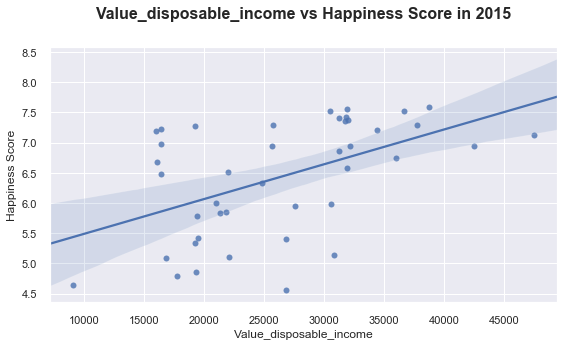

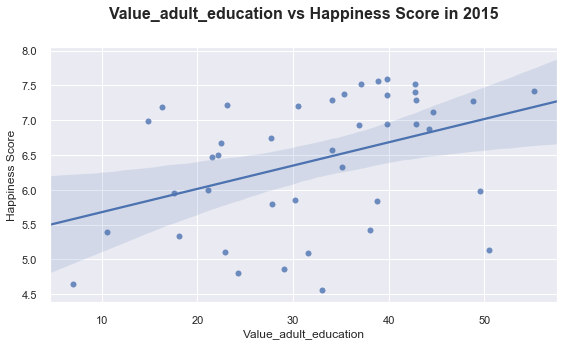

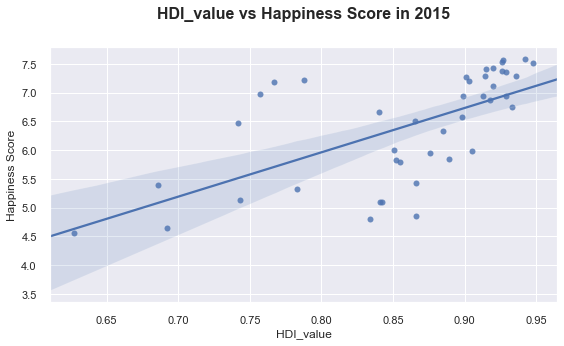

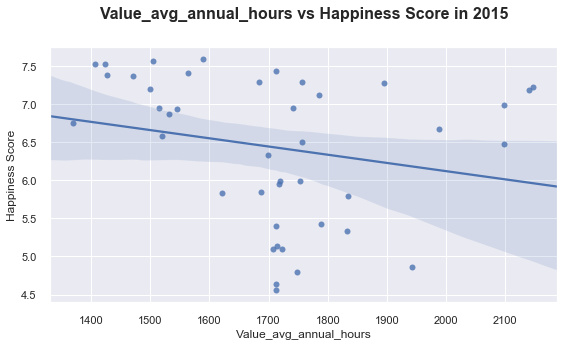

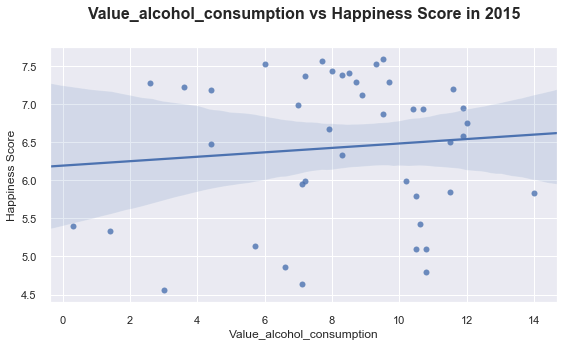

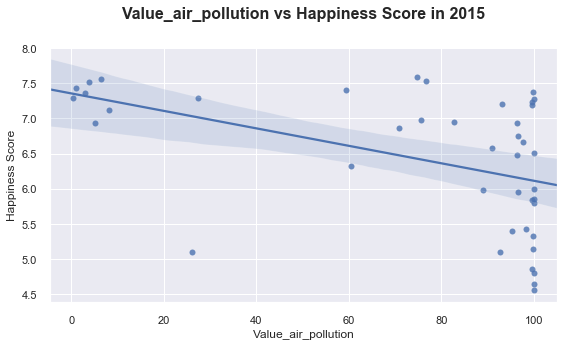

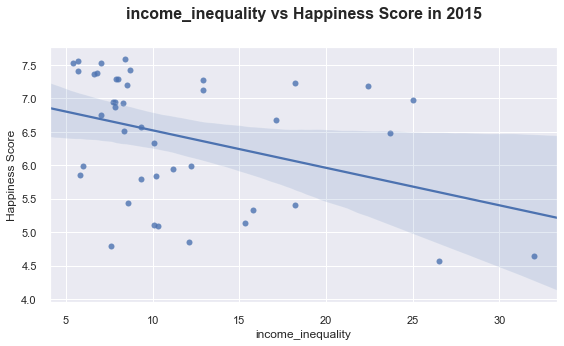

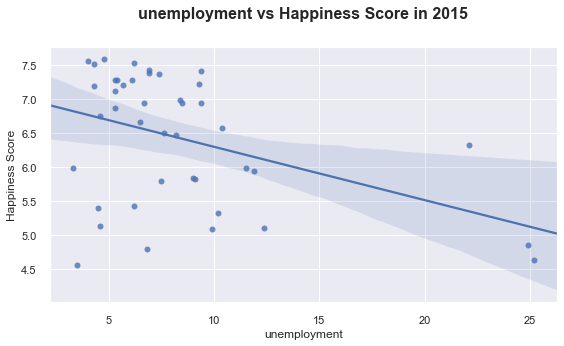

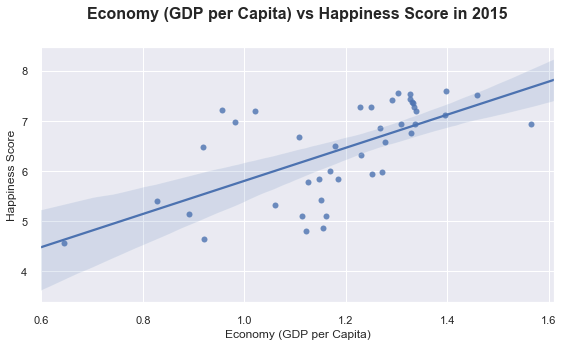

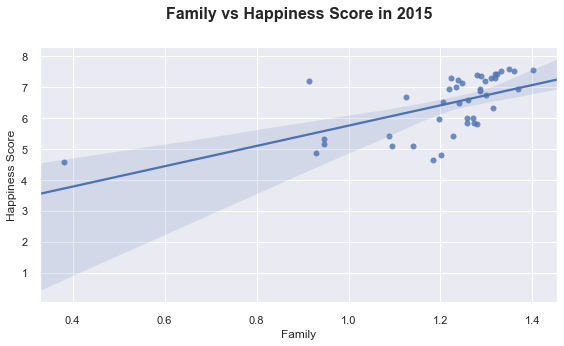

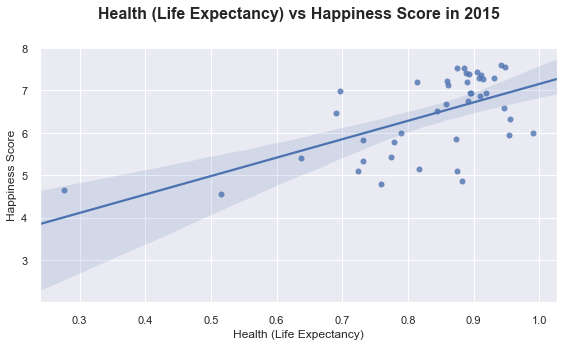

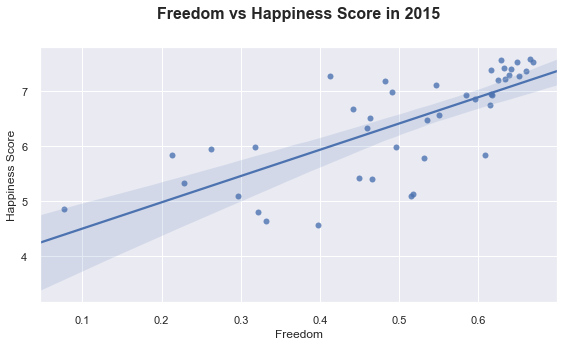

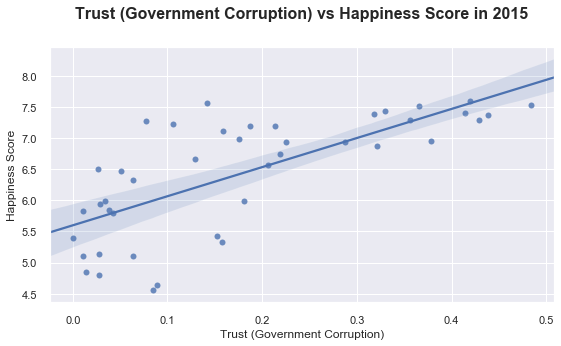

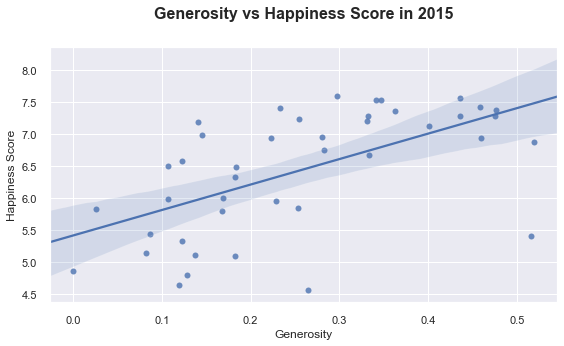

In [20]:
## Draw plots to check if linear relationship exists between
possible_features = [
        'Value_disposable_income','Value_adult_education',
         'HDI_value','Value_avg_annual_hours',
        'Value_alcohol_consumption', 'Value_air_pollution',
        'income_inequality',
       'unemployment', 
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity']

for feature in possible_features:
    fig, ax = plt.subplots(figsize=(8,5))
    title = feature + " vs Happiness Score in 2015"
    ax = sns.regplot(x=feature, y="Happiness Score", data=df[df['TIME']==2015])
    #sns.scatterplot("Happiness Rank","Happiness Score", hue = 'TIME', data=df)
    ax.text(x=0.5, y=1.1, s=title, fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    fig.tight_layout()
    plt.show()

### Split train and test dataset
- We use 2015 and 2016 data as trainset
- 2017 data for testing

In [21]:
train = df[df['TIME']!=2017]
test = df[df['TIME']==2017]

In [22]:
print(len(train)/(len(train)+len(test)))

0.6746031746031746


Thus, around 67% data in train set

In [23]:
X_train = train[possible_features]
X_test = test[possible_features]  # 9 features

y_train = train['Happiness Score']
y_test = test['Happiness Score']

y_test = y_test.as_matrix() 

## Normalization variables

In [42]:
def standardization(features_group, X_train, X_test):
    for feature in features_group:
         ### get mean and std from train dataset
        (mu_train, sigma_train) = norm.fit(X_train[feature])
        ### normalization this feature
        X_train[feature] = (X_train[feature] - mu_train) / sigma_train
        X_test[feature] = (X_test[feature] - mu_train) / sigma_train
    return X_train, X_test

X_train, X_test = standardization(possible_features, X_train, X_test)

In [25]:
from sklearn.metrics import mean_squared_error 
import sklearn.metrics as metrics
"""
Method to evaluate model performance based on true data and predicted data in testset.
"""
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Model 1: Baeline: Linear regression

#### Feature selection

In [26]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS  
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

linear_regression = LinearRegression()
### Sequential Forward Selection
sfs = SFS(linear_regression, 
          k_features=(4, 14), # select most reasonable features within range 4 to 14
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)  # 10-fold cross-validation on the training set.
sfs = sfs.fit(X_train, y_train)
print('Selected features:', sfs.k_feature_idx_) # the index of selected features.

Selected features: (0, 3, 8, 9, 10, 12, 13)


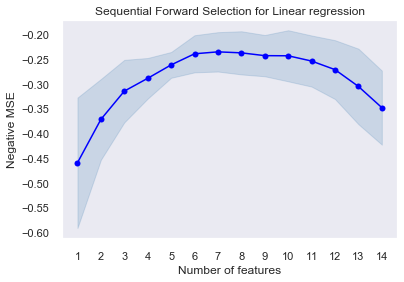

In [27]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection for Linear regression')
plt.grid()
plt.ylabel('Negative MSE')
plt.xlabel('Number of features')
plt.show()


We can see the model achieve best perfromance when using 7 variables.

In [28]:
selected_features =['Value_disposable_income','Value_avg_annual_hours', 'Economy (GDP per Capita)', 'Family', 
                    'Health (Life Expectancy)','Trust (Government Corruption)', 'Generosity']
## Create new train dataset based on new features
X_train_linear = X_train[selected_features]
X_test_linear = X_test[selected_features]

In [29]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression.fit(X_train_linear, y_train)

print('Intercept: \n', linear_regression.intercept_)
print('Coefficients: \n', linear_regression.coef_)
r_sq = linear_regression.score(X_train_linear, y_train)
print('coefficient of determination: \n', r_sq)

Intercept: 
 6.429870588235295
Coefficients: 
 [0.1022099  0.34518179 0.22518494 0.1951286  0.14364598 0.36897174
 0.24753753]
coefficient of determination: 
 0.7789240720443047



---------------Evaluation----------------------------------
explained_variance:  0.7357
mean_squared_log_error:  0.0046
r2:  0.5615
MAE:  0.3842
MSE:  0.2543
RMSE:  0.5043


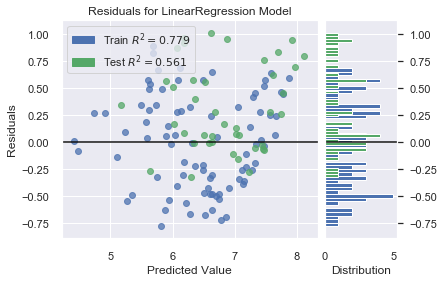

In [30]:
print("\n---------------Evaluation----------------------------------")
y_pred = linear_regression.predict(X_test_linear) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
visualizer = ResidualsPlot(linear_regression)
visualizer.fit(X_train_linear, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_linear, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#pred_actual_table

No, thus we consider add penalty factor to model

## Model 2: KNN
Since no clear linear pattern, so we try KNN to see if can get better result

-0.47010485555555537
-0.365758950347222
-0.4076281447530864
-0.36365832074652776
-0.3403381964444444
-0.343694351890432
-0.36720948744331056
-0.37628153148871524
-0.388455421399177
-0.3854208185277777
-0.3896507408516988
-0.39382571815200623
-0.38893978342373436
-0.3836041653344672
-0.37951613687654334
-0.3920359017144097
-0.3997915212562476
-0.4038888391032237
-0.39711591326562024
-0.3980231193159723


Text(0.5, 1.0, 'The Negative MSE of different neighbors')

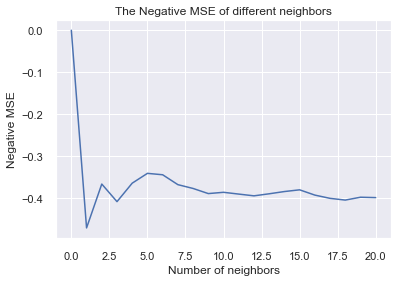

In [43]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
rmse_val = [0] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    rmse_val.append(scores.mean())  # Save the mean of 10 folders. 
    print(scores.mean())
    
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
#curve.plot()
plt.plot(curve)
plt.ylabel('Negative MSE')
plt.xlabel('Number of neighbors')
plt.title("The Negative MSE of different neighbors")

Thus , best K is k = 5.

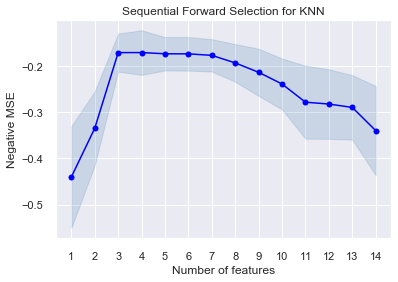

Selected features: (2, 3, 12, 13)


In [44]:
## forword variable selection
KNN = neighbors.KNeighborsRegressor(n_neighbors = 5)  # select k = 5
sfs = SFS(KNN, 
          k_features=(4, 14), # select most reasonable features within range 6 to 14 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)
sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.grid()
plt.title('Sequential Forward Selection for KNN')
plt.grid()
plt.ylabel('Negative MSE')
plt.xlabel('Number of features')
plt.show()

print('Selected features:', sfs.k_feature_idx_)

In [33]:
selected_features = ['HDI_value', 'Value_avg_annual_hours', 'Trust (Government Corruption)', 'Generosity']
## Create new train dataset based on new features
X_train_KNN = X_train[selected_features]
X_test_KNN = X_test[selected_features]


---------------Evaluation----------------------------------
explained_variance:  0.8895
mean_squared_log_error:  0.0012
r2:  0.8895
MAE:  0.2067
MSE:  0.0641
RMSE:  0.2532


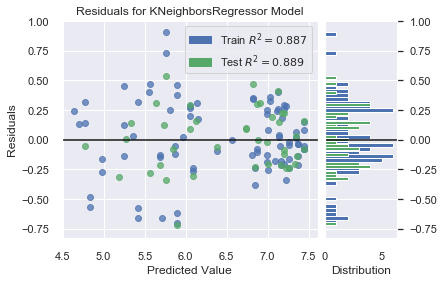

In [46]:
KNN = neighbors.KNeighborsRegressor(n_neighbors = 5)  # select k = 5
KNN.fit(X_train_KNN, y_train)

print("\n---------------Evaluation----------------------------------")
y_pred = KNN.predict(X_test_KNN) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(KNN)
visualizer.fit(X_train_KNN, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_KNN, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#pred_actual_table


---------------Evaluation----------------------------------
explained_variance:  0.845
mean_squared_log_error:  0.0018
r2:  0.8416
MAE:  0.236
MSE:  0.0919
RMSE:  0.3031


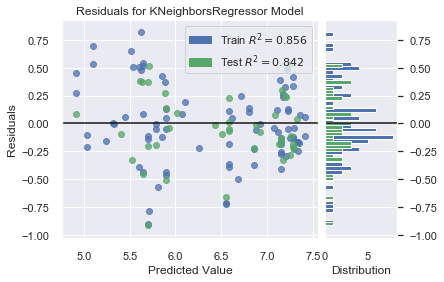

In [51]:
KNN2 = neighbors.KNeighborsRegressor(n_neighbors = 10)  # select k = 10
KNN2.fit(X_train_KNN, y_train)

print("\n---------------Evaluation----------------------------------")
y_pred = KNN2.predict(X_test_KNN) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(KNN2)
visualizer.fit(X_train_KNN, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_KNN, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure
pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#pred_actual_table

### Model: decision tree

In [36]:
#### find optimal depth:
rmse_val = [0] #to store rmse values for different k
for depth in range(1, 20):
    decision_tree = DecisionTreeRegressor(random_state = 0,max_depth= depth)  
    scores = cross_val_score(decision_tree, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    rmse_val.append(scores.mean())

Text(0.5, 1.0, 'The Negative MSE of different max depth')

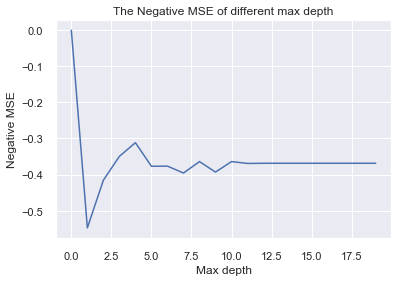

In [37]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
#curve.plot()
plt.plot(curve)
plt.ylabel('Negative MSE')
plt.xlabel('Max depth')
plt.title("The Negative MSE of different max depth")

Based on the result above, the optimal depth is 4.

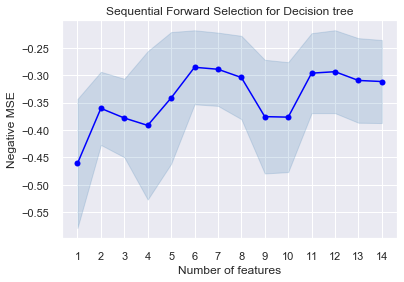

Selected features: (0, 2, 3, 5, 10, 11)


In [38]:
## forword variable selection
decision_tree = DecisionTreeRegressor(random_state = 0,max_depth=4)  
sfs = SFS(decision_tree, 
          k_features=(6, 14),
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)


sfs = sfs.fit(X_train, y_train)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection for Decision tree')
plt.grid()
plt.ylabel('Negative MSE')
plt.xlabel('Number of features')
plt.grid()
plt.show()

print('Selected features:', sfs.k_feature_idx_) # 14 features still give as the best model performance

In [39]:
selected_features = ['Value_disposable_income', 'HDI_value', 'Value_avg_annual_hours', 
                     'Health (Life Expectancy)','Freedom']
## Create new train dataset based on new features
X_train_tree = X_train[selected_features]
X_test_tree = X_test[selected_features]

decision_tree = DecisionTreeRegressor(random_state = 0,max_depth=4)  
decision_tree.fit(X_train_tree, y_train)


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')


---------------Evaluation----------------------------------
explained_variance:  0.7401
mean_squared_log_error:  0.003
r2:  0.7392
MAE:  0.2596
MSE:  0.1513
RMSE:  0.389


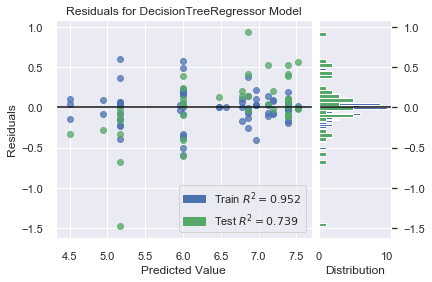

In [40]:

print("\n---------------Evaluation----------------------------------")
y_pred = decision_tree.predict(X_test_tree) # predict
regression_results(y_test, y_pred)

#### Create Residual Plots
visualizer = ResidualsPlot(decision_tree)
visualizer.fit(X_train_tree, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_tree, y_test)  # Evaluate the model on the test data
visualizer.show()   

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#pred_actual_table